In [10]:
filepattern = "tabby/dataset/data.jsonl"
api = "http://localhost:8080"
max_records = "3"

In [11]:
max_records = int(max_records)

In [64]:
import pandas as pd

from tabby_client import Client
from tabby_client.api.v1 import health
from tabby_client.api.v1 import completion

from tabby_client.models import CompletionRequest, CompletionRequest, Segments, Choice

import processing
import editdistance
import random


def valid_item(item: processing.Item):
    count_body_lines = len(item.body.splitlines())

    if count_body_lines > 10:
        return False

    return True


def scorer(label, prediction):
    distance = editdistance.eval(label, prediction)
    return max(0.0, 1.0 - distance / len(label))


def run_eval():
    client = Client(base_url=api, timeout=50)
    try:
        health.sync(client=client)
    except:
        print(f"Tabby Server is not ready, please check if '{api}' is correct.")
        return
    
    items = [x for x in processing.items_from_filepattern(filepattern) if valid_item(x)];
    if len(items) > max_records:
        random.seed(0xbadbeef)
        items = random.sample(items, max_records)
    

    for item in items:
        if not valid_item(item):
            continue

        request = CompletionRequest(
            language=item.language, segments=Segments(prefix=item.prefix)
        )

        resp: CompletionResponse = completion.sync(client=client, json_body=request)
        label = item.body
        prediction = resp.choices[0].text

        block_score = scorer(label, prediction)
        
        label_lines = label.splitlines()
        prediction_lines = prediction.splitlines()
        
        if len(label_lines) > 0 and len(prediction_lines) > 0:
            line_score = scorer(label_lines[0], prediction_lines[0])

        yield dict(
            prompt=item.prefix,
            prediction=prediction,
            label=label,
            block_score=block_score,
            line_score=line_score,
        )

In [65]:
df = pd.DataFrame(list(run_eval()))

array([<Axes: title={'center': 'block_score'}>], dtype=object)

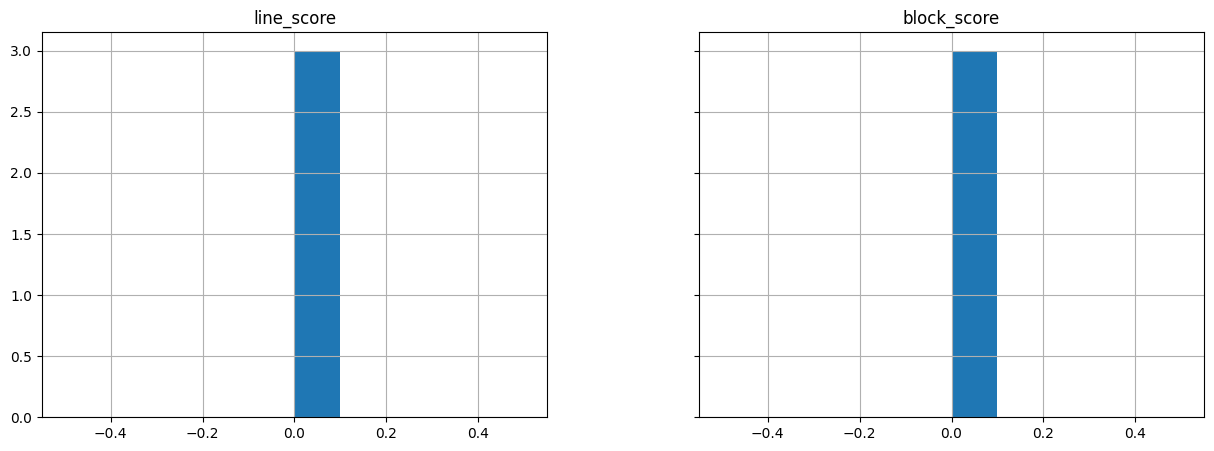

In [66]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(15, 5))

df.hist(
    column="line_score",
    ax=axes[0],
)

df.hist(
    column="block_score",
    ax=axes[1],
)

In [67]:
codeStyle = {
    "selector": "td",
    "props": [
        ("white-space", "pre"),
        ("font-family", "monospace"),
        ("text-align", "left"),
        ("max-width", "400px"),
        ("overflow-x", "scroll"),
    ],
}

df.style.set_table_styles(
    {
        "prompt": [codeStyle],
        "prediction": [codeStyle],
        "label": [codeStyle],
    }
)

,prompt,prediction,label,block_score,line_score
0,"attentions=all_attentions, cross_attentions=all_cross_attentions, ) class T5ForConditionalGeneration(T5PreTrainedModel): def __init__(self, config: T5Config, weights): super().__init__(config) self.model_dim = config.d_model try: self.shared = TensorParallelEmbedding(prefix=""shared"", weights=weights) except RuntimeError: self.shared = TensorParallelEmbedding(prefix=""encoder.embed_tokens"", weights=weights) encoder_config = copy.deepcopy(config) encoder_config.is_decoder = False encoder_config.use_cache = False encoder_config.is_encoder_decoder = False self.encoder =","/* * Copyright (c) 2008-2021, Hazelcast, Inc. All Rights Reserved. * * Licensed under the Apache License, Version 2.0 (the ""License""); * you may not use this file except in compliance with the License. * You may obtain a copy of the License at * * http://www.apache.org/licenses/LICENSE-2.0 * * Unless required by applicable law or agreed to in writing, software * distributed under the License is distributed on an ""AS IS"" BASIS,","T5Stack( config=encoder_config, prefix=""encoder"", weights=weights, embed_tokens=self.shared, )",0.000000,0.000000
1,"past_present_indices, past_key_values: Optional[torch.Tensor] = None, pre_allocate_past_size: Optional[int] = None, lm_head_indices: Optional[torch.Tensor] = None, ): hidden_states, present = self.gpt_neox( input_ids, position_ids, start_seq, end_seq, start_seq_q, end_seq_q, max_s, past_present_indices, past_key_values, pre_allocate_past_size, ) if lm_head_indices is not None: hidden_states = hidden_states[lm_head_indices] logits =","/* * Copyright (c) 2008-2021, Hazelcast, Inc. All Rights Reserved. * * Licensed under the Apache License, Version 2.0 (the ""License""); * you may not use this file except in compliance with the License. * You may obtain a copy of the License at * * http://www.apache.org/licenses/LICENSE-2.0 * * Unless required by applicable law or agreed to in writing, software * distributed under the License is distributed on an ""AS IS"" BASIS,",self.embed_out(hidden_states),0.000000,0.000000
2,"if not isinstance(serialized_data, List): serialized_data = [serialized_data] if not isinstance(snapshot_data, List): snapshot_data = [snapshot_data] return len(snapshot_data) == len(serialized_data) and all( [eq_response(r, o) for r, o in zip(serialized_data, snapshot_data)] ) class LauncherHandle: def __init__(self, port: int): self.client = AsyncClient(f""http://localhost:{port}"") def _inner_health(self): raise NotImplementedError async def health(self, timeout: int = 60): assert timeout > 0 for _ in","/* * Copyright (c) 2008-2021, Hazelcast, Inc. All Rights Reserved. * * Licensed under the Apache License, Version 2.0 (the ""License""); * you may not use this file except in compliance with the License. * You may obtain a copy of the License at * * http://www.apache.org/licenses/LICENSE-2.0 * * Unless required by applicable law or agreed to in writing, software * distributed under the License is distributed on an ""AS IS"" BASIS,",range(timeout),0.000000,0.000000
